In [37]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
with open("../tracker_stubs/ball_detections.pkl", "rb") as f:
    ball_positions = pickle.load(f)

In [39]:
df_ball_positions = (
    pd.DataFrame(
        [x.get(1, []) for x in ball_positions], columns=["x1", "y1", "x2", "y2"]
    )
    .interpolate()  # Interpolate missing frames
    .bfill()
)

In [40]:
df_ball_positions["mid_y"] = (df_ball_positions["y1"] + df_ball_positions["y2"]) / 2
df_ball_positions["mid_y_rolling_mean"] = df_ball_positions["mid_y"].rolling(10).mean()

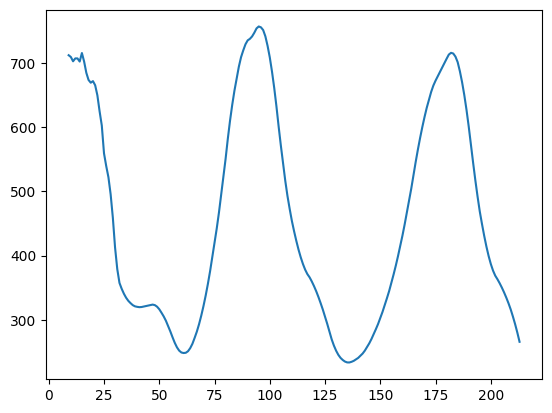

In [41]:
plt.plot(df_ball_positions["mid_y_rolling_mean"])

In [42]:
df_ball_positions["delta_y"] = df_ball_positions["mid_y_rolling_mean"].diff()

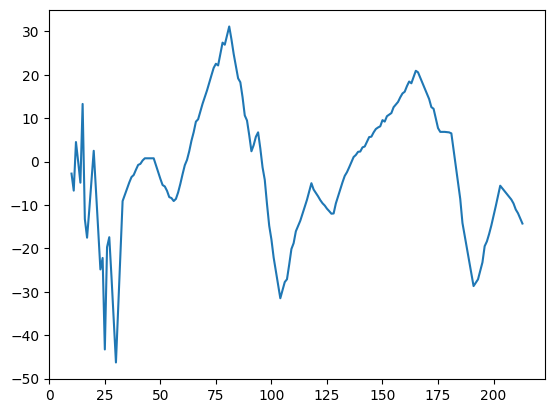

In [43]:
plt.plot(df_ball_positions["delta_y"])

In [44]:
df_ball_positions["ball_hit"] = 0

In [45]:
df_ball_positions["mid_y"] = (df_ball_positions["y1"] + df_ball_positions["y2"]) / 2
df_ball_positions["mid_y_rolling_mean"] = df_ball_positions["mid_y"].rolling(10).mean()
df_ball_positions["delta_y"] = df_ball_positions["mid_y_rolling_mean"].diff()

minimum_changes_to_detect_hit = 25
for i in range(1, len(df_ball_positions) - int(minimum_changes_to_detect_hit * 1.2)):
    neg_position_change = (
        df_ball_positions["delta_y"].iloc[i] > 0
        and df_ball_positions["delta_y"].iloc[i + 1] < 0
    )
    pos_position_change = (
        df_ball_positions["delta_y"].iloc[i] < 0
        and df_ball_positions["delta_y"].iloc[i + 1] > 0
    )

    if neg_position_change or pos_position_change:
        change_count = 0
        for change_frame in range(
            i + 1, i + int(minimum_changes_to_detect_hit * 1.2) + 1
        ):
            neg_position_change_next = (
                df_ball_positions["delta_y"].iloc[i] > 0
                and df_ball_positions["delta_y"].iloc[change_frame] < 0
            )
            pos_position_change_next = (
                df_ball_positions["delta_y"].iloc[i] < 0
                and df_ball_positions["delta_y"].iloc[change_frame] > 0
            )

            if neg_position_change and neg_position_change_next:
                change_count += 1
            elif pos_position_change and pos_position_change_next:
                change_count += 1

        if change_count > minimum_changes_to_detect_hit - 1:
            df_ball_positions["ball_hit"].iloc[i] = 1

frame_nums_ball_hit = df_ball_positions[
    df_ball_positions["ball_hit"] == 1
].index.tolist()

/tmp/ipykernel_11936/670440979.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/tmp/ipykernel_11936/670440979.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [46]:
df_ball_positions[df_ball_positions["ball_hit"] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
12,783.403015,680.010193,807.451355,704.901581,692.455887,706.990681,4.498683,1
15,797.532471,803.674622,817.166504,823.607117,813.640869,715.362842,13.278188,1
61,894.573364,249.417068,915.371582,270.949677,260.183372,248.427618,-0.842681,1
95,623.291748,746.176880,643.518677,767.170837,756.673859,756.681195,3.019119,1
136,751.447876,225.776459,772.517456,249.243622,237.510040,233.709190,-0.111195,1
182,1279.887939,697.187698,1302.705566,722.644455,709.916077,715.658952,2.724495,1


[12, 15, 61, 95, 136, 182]